In [65]:
import pandas as pd
import numpy as np

import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.windows import from_bounds
import xarray as xr

import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches

import yaml

from utils import geo, data

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

from atlite.gis import ExclusionContainer

import matplotlib.pyplot as plt; plt.style.use('seaborn-colorblind')
import matplotlib.colors as pltc
import style; figsize = style.configure(document_fontsize = 10.95, available_width = 394.78204)
from style import lighten_color

### 0 . Preliminaries

In [62]:
ROOT = 'C:/CaT/Masterthesis/repository/'
LUISA = ROOT + 'data/input_geodata/luisa.tif'
CORINE = ROOT + 'data/input_geodata/corine.tif'

# Excel with necessary information on the shapes luisa / corine cover, as well as the gridcodes
gc_excel = pd.read_excel(ROOT + 'data/gridcode_dict.xlsx', sheet_name = 'py_dict_format', 
                         converters = {'in_gc_luisa' : int, 'in_gc_corine' : int, 'ex_gc_luisa' : int, 'ex_gc_corine': int})

gridcodes = {
    'inclusion' : 
    {
        'luisa' : dict(zip(gc_excel['in_gc_type'], gc_excel['in_gc_luisa'])),
        'corine' : dict(zip(gc_excel['in_gc_type'], gc_excel['in_gc_corine']))
    },
    'exclusion' :
    {
        'luisa' : dict(zip(gc_excel['ex_gc_type_luisa'].dropna(), gc_excel['ex_gc_luisa'].dropna())),
        'corine' : dict(zip(gc_excel['ex_gc_type_corine'].dropna(), gc_excel['ex_gc_corine'].dropna()))
    }
}

clrs = {'darkblue' : plt.rcParams['axes.prop_cycle'].by_key()['color'][0],
         'green' : plt.rcParams['axes.prop_cycle'].by_key()['color'][1],
         'orange' : plt.rcParams['axes.prop_cycle'].by_key()['color'][2],
         'pink' : plt.rcParams['axes.prop_cycle'].by_key()['color'][3],
         'yellow' : plt.rcParams['axes.prop_cycle'].by_key()['color'][4],
         'lightblue' : plt.rcParams['axes.prop_cycle'].by_key()['color'][5]}


# Analysis

## 1. Introduction

## 2. Literature Review

## 3. Data

### Figure 3.2.1

In [3]:
#States
shpfilename = shpreader.natural_earth(resolution='10m',
                                          category='cultural',
                                          name='admin_1_states_provinces_lines')
    
states = gpd.read_file(shpfilename)[['ADM0_NAME', 'NAME', 'geometry']]
berlin = states.to_crs(3035).query("NAME == 'Berlin - Brandenburg'")

In [36]:
from rasterio.windows import from_bounds

buffer = 5000

with rio.open(LUISA) as f:
    
    window = from_bounds(berlin.bounds['minx'].values - buffer,
                         berlin.bounds['miny'].values - buffer,
                         berlin.bounds['maxx'].values + buffer,
                         berlin.bounds['maxy'].values + buffer,
                         f.transform)
    
    luisa = f.read(1, window = window)
    transform_luisa = rio.windows.transform(window, f.transform)
    
    
with rio.open(CORINE) as f:
    
    window = from_bounds(berlin.bounds['minx'].values - buffer,
                         berlin.bounds['miny'].values - buffer,
                         berlin.bounds['maxx'].values + buffer,
                         berlin.bounds['maxy'].values + buffer,
                         f.transform)
    
    corine = f.read(1, window = window)
    transform_corine = rio.windows.transform(window, f.transform)
    
luisa_labs_cols = {'High density urban fabric' : clrs['darkblue'],
                   'Medium density urban fabric' : style.lighten_color(clrs['green'], 1.25), 
                   'Low density urban fabric' : clrs['green'],
                   'Isolated or very low density urban fabric' : style.lighten_color(clrs['green'], 0.75),              
                   'Industrial or commercial units' : clrs['orange'],
                   'Road and rail networks and associated land' : style.lighten_color(clrs['orange'], 1.25)}
    
corine_labs_cols = {'Continuous urban fabric' : clrs['darkblue'],
                    'Discontinuous urban fabric' : clrs['green'], 
                    'Industrial or commercial units' : clrs['orange'],
                    'Road and rail networks and associated land' : style.lighten_color(clrs['orange'], 1.25)}    

gc_luisa = [gridcodes['exclusion']['luisa'][i] for i in luisa_labs_cols.keys()]
gc_corine = [gridcodes['exclusion']['corine'][i] for i in corine_labs_cols.keys()]
    
luisa_plot = np.isin(luisa, [gc_luisa])  * luisa
corine_plot = np.isin(corine, [gc_corine])  * corine

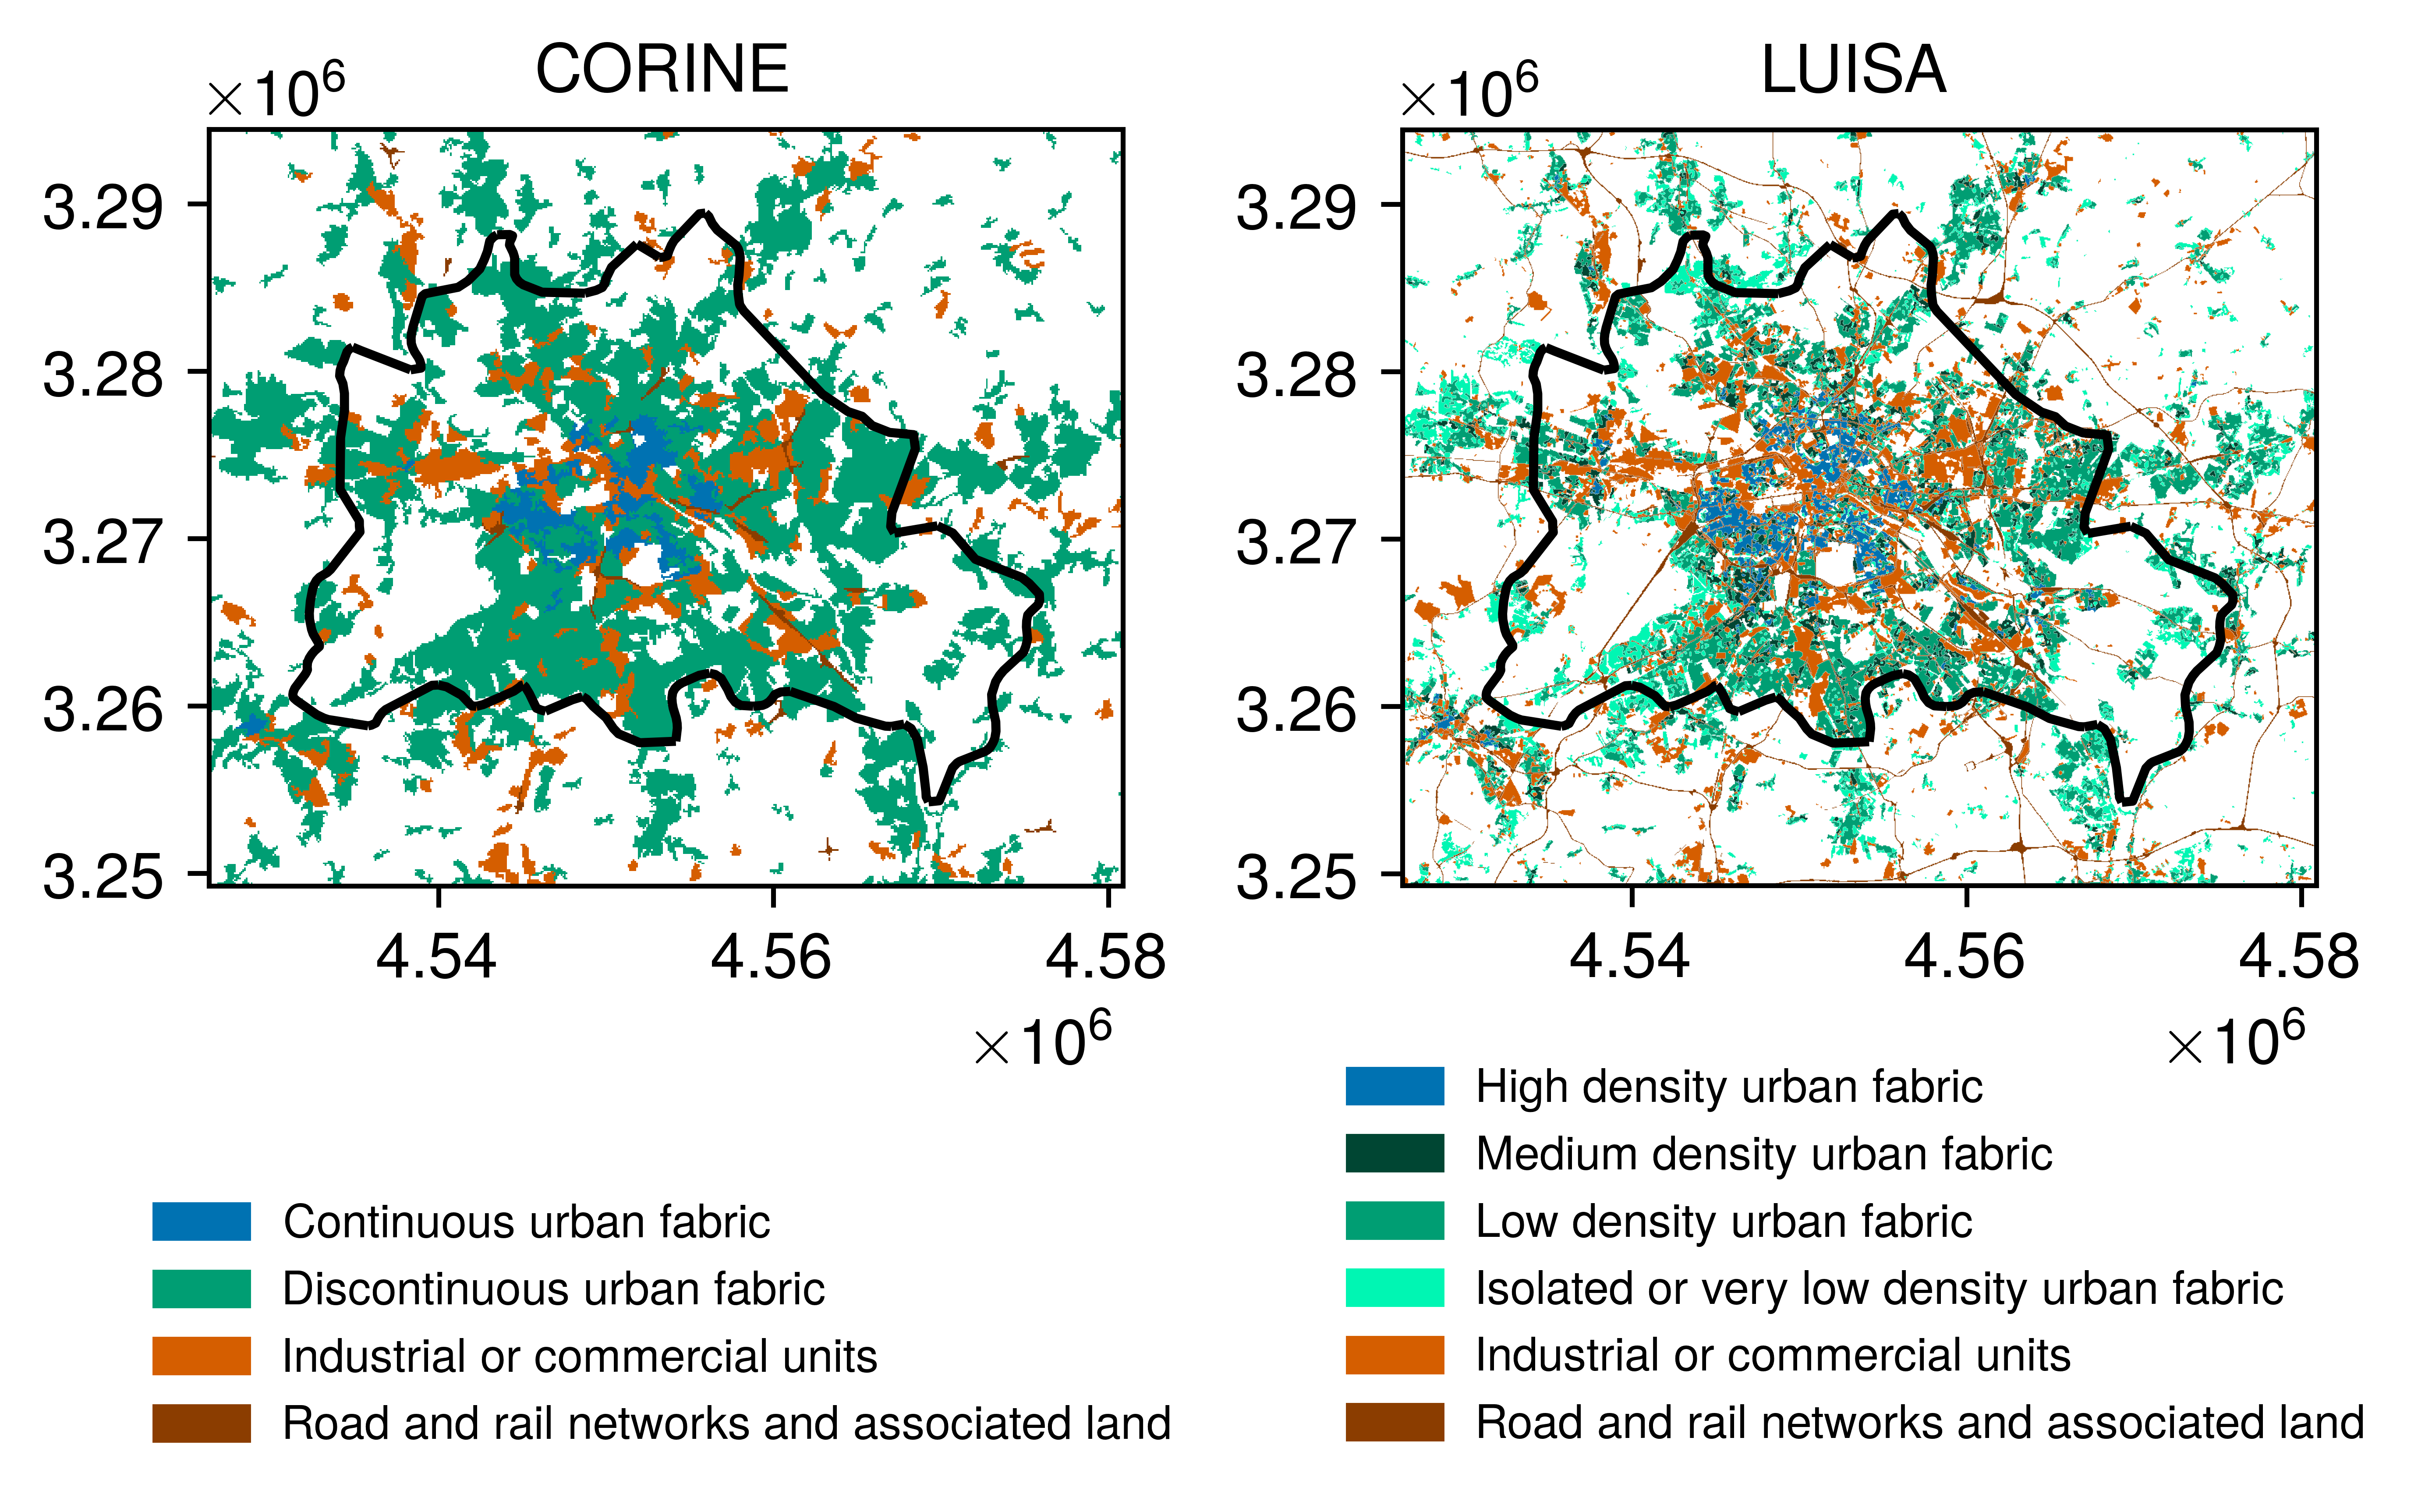

In [48]:
c_transparent = pltc.colorConverter.to_rgba('white',alpha = 0)

fig, ax = plt.subplots(1 , 2, figsize=figsize(1), dpi = 1000) 

#left plot
patches = []

for g,l,c in zip(gc_corine, corine_labs_cols.keys(), corine_labs_cols.values()):
               
    cmap = pltc.LinearSegmentedColormap.from_list('rb_cmap',[c_transparent, c],512)
               

    show(np.isin(corine_plot, [g]) , transform = transform_corine, cmap = cmap, label = l, ax=ax[0])

    
patches = [mpatches.Patch(color=c, label=l) for l,c in zip(corine_labs_cols.keys(), corine_labs_cols.values())]
ax[0].legend(handles = patches, loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=1, frameon=False, fontsize = 'x-small')


berlin.plot(edgecolor = 'k', ax=ax[0])
ax[0].set_title('CORINE')


for g,l,c in zip(gc_luisa, luisa_labs_cols.keys(), luisa_labs_cols.values()):
               
    cmap = pltc.LinearSegmentedColormap.from_list('rb_cmap',[c_transparent, c],512)
               

    show(np.isin(luisa_plot, [g]) , transform = transform_luisa, cmap = cmap, label = l, ax=ax[1])
    
patches = [mpatches.Patch(color=c, label=l) for l,c in zip(luisa_labs_cols.keys(), luisa_labs_cols.values())]
ax[1].legend(handles = patches, loc="lower center", bbox_to_anchor=(0.5, -0.8), ncol=1, frameon=False,  fontsize = 'x-small')

berlin.plot(edgecolor = 'k', ax=ax[1])
ax[1].set_title('LUISA')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/corine_luisa_berlin.pdf', bbox_inches = 'tight')

## 3.2.1 Table

In [ ]:
#forest_d = {'Broad-leaved forest', 'Coniferous forest', 'Mixed forest'}
forest_d = {'Bare rock'}

with open(ROOT + "/windgenpotential/countrycode.yaml", 'r') as stream:
    countrycode = yaml.safe_load(stream)  

countries = [i for i in countrycode.keys()]
d = {}

for cntry in countries:
    
    country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    
    exc = ExclusionContainer(res=50)

    exc.add_raster(LUISA, codes = [gridcodes['inclusion']['luisa'][x] for x in forest_d], crs=3035, invert = True)

    forest = geo.mte(exc, country.geometry, share_kind = 'normal')
    
    d[cntry] = {'area' : forest[2], 'share' : forest[3]}
    
forest_analysis = pd.DataFrame.from_dict(d, orient = 'index', columns = ['area', 'share'])
#forest_analysis.to_csv(ROOT + 'results/forest_share.csv')

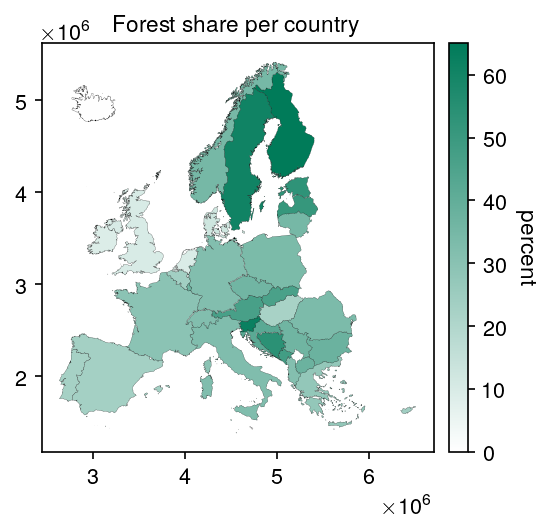

In [123]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['green'], 1.1)])

fig, ax = plt.subplots(figsize = figsize(1), dpi = 150)


divider = make_axes_locatable(ax)

cax = divider.append_axes("right", size="5%", pad=0.1)


for cntry in countries:
    country = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    country['share'] = forest_analysis.loc[cntry, 'share'] * 100
    if cntry == countries[0]:
        country.plot('share', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 65, legend = True, ax = ax, cax=cax)

    else:
        country.plot('share', edgecolor = 'k', lw = 0.1, cmap = cmap, vmin = 0, vmax = 65, legend = False, ax = ax)
        
cax.set_ylabel('percent', rotation = 270, labelpad = 15)        
ax.set_title('Forest share per country')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/forest_share_map.pdf')
    

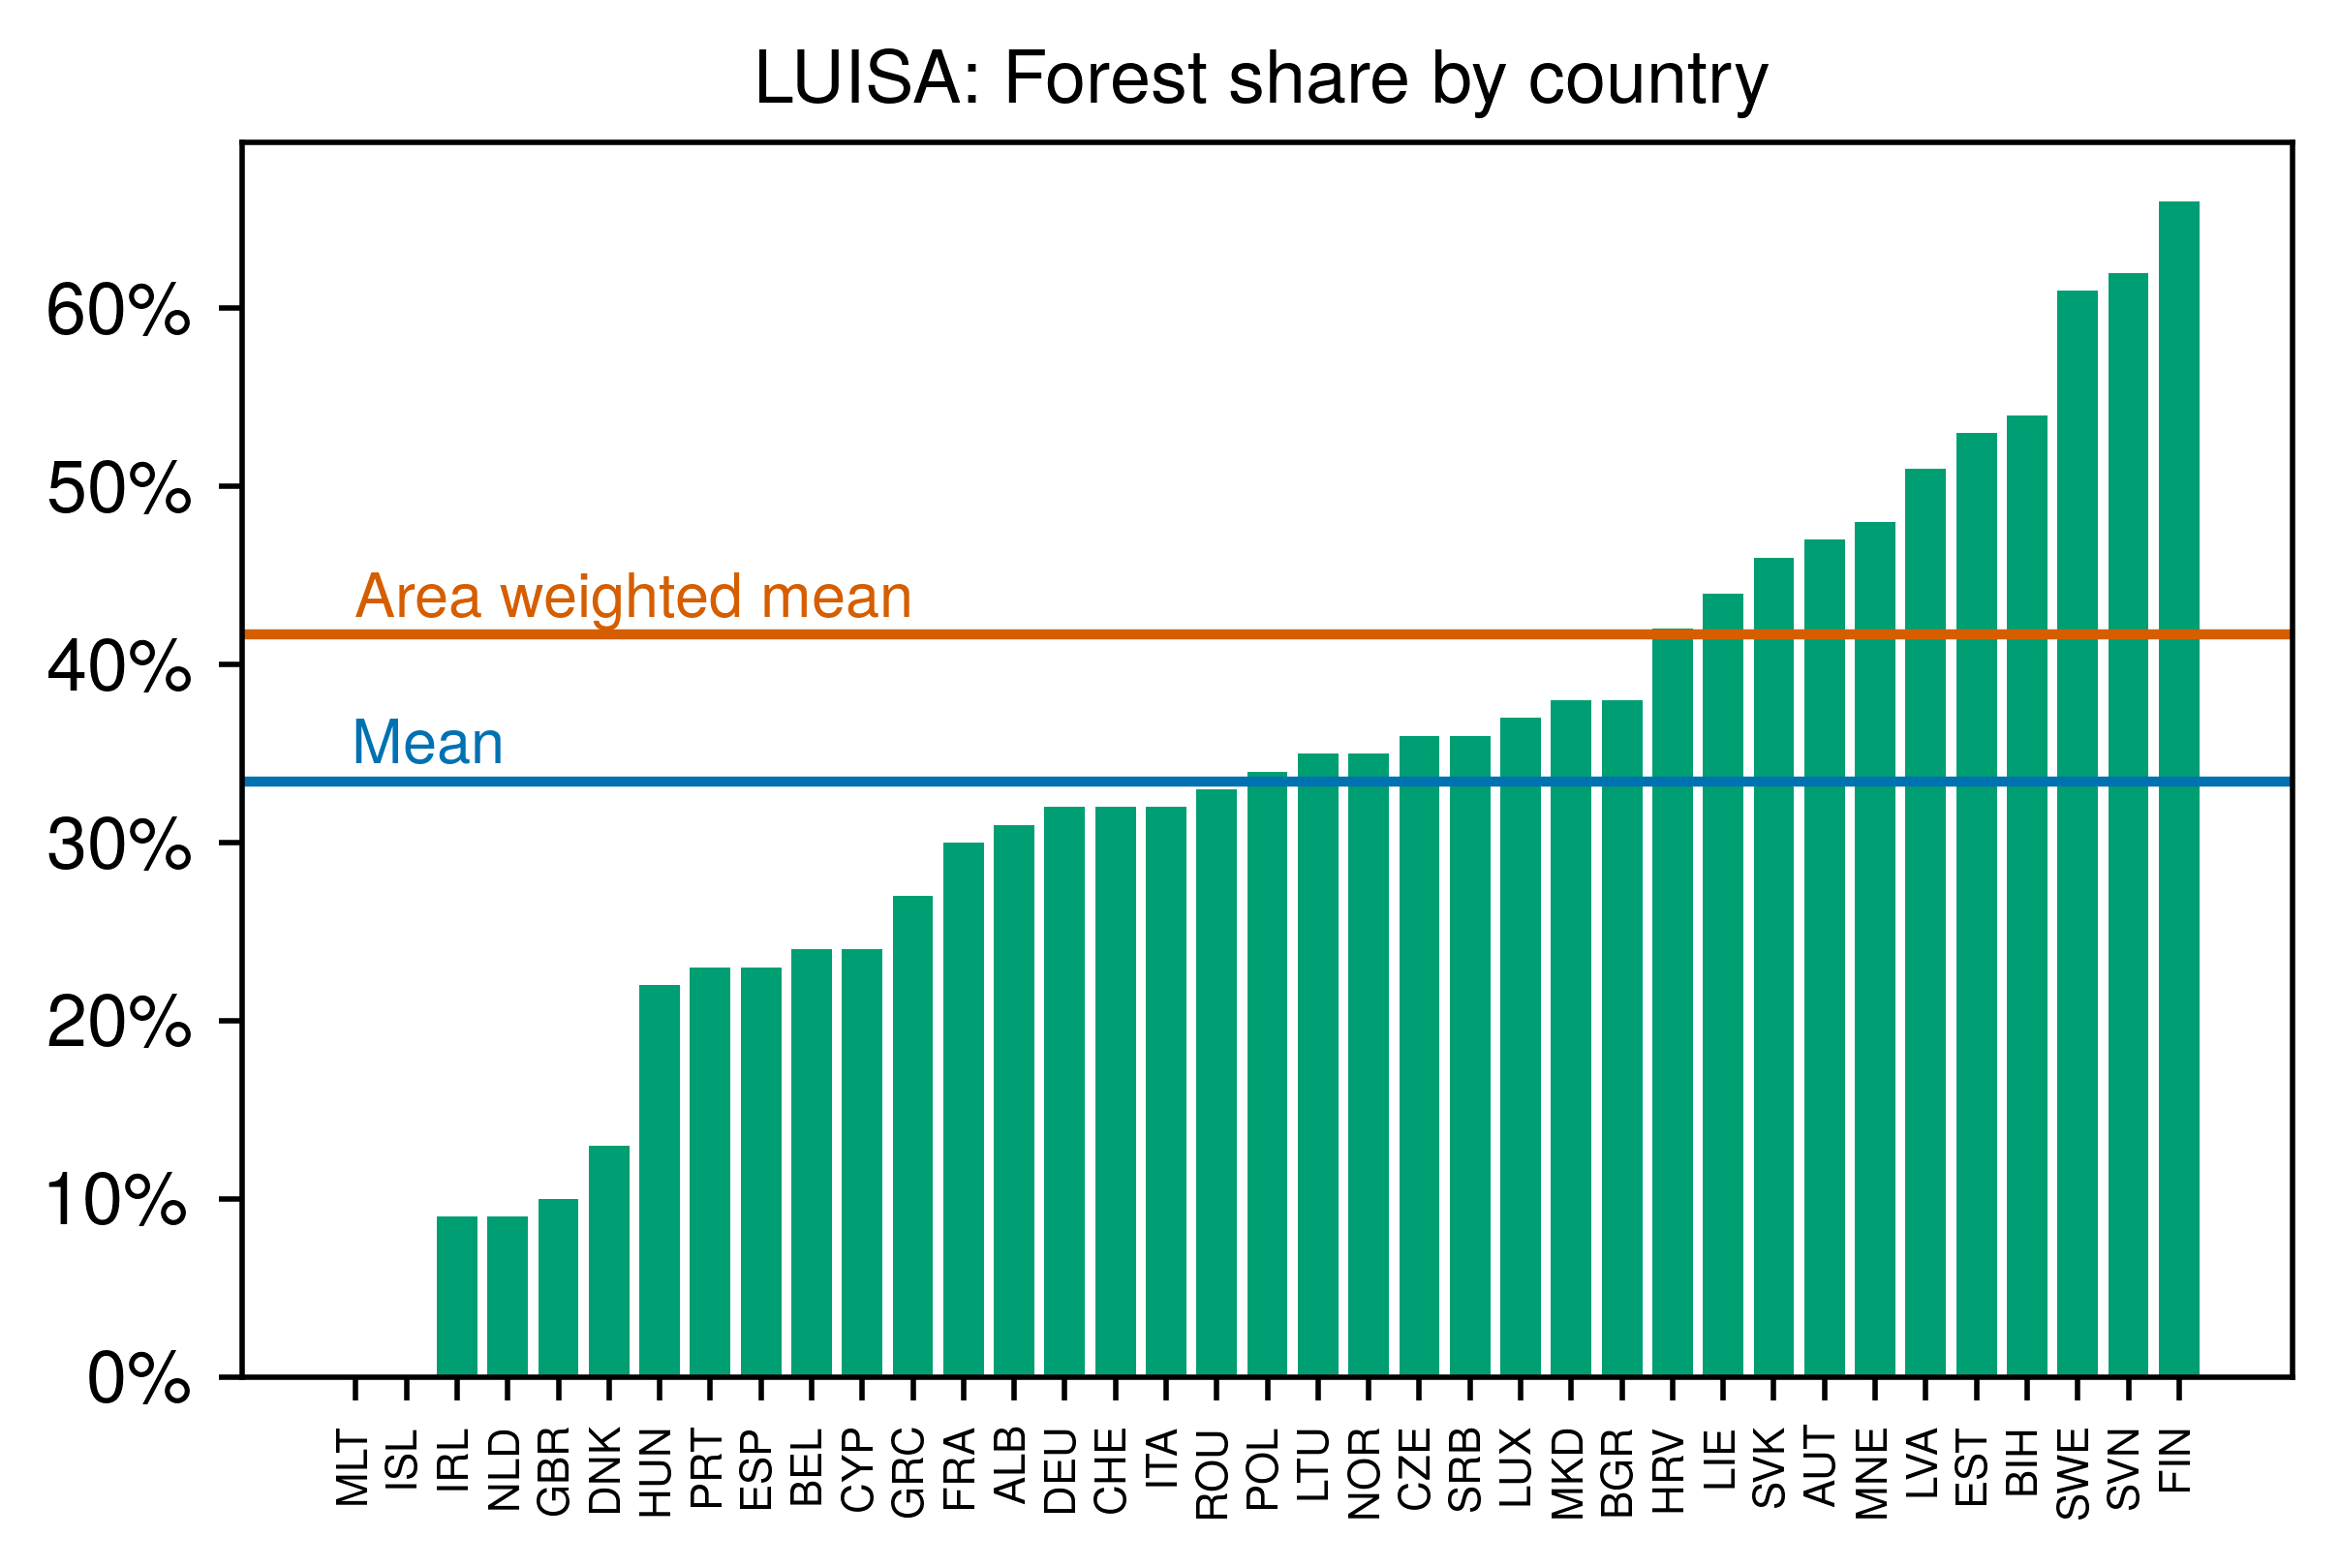

In [185]:
forest_share_sorted = forest_analysis.sort_values('share')
mean = np.mean(forest_share_sorted.share)
areaweighted_mean = np.sum(forest_analysis.area * forest_analysis.share) / np.sum(forest_analysis.area)

fig, ax = plt.subplots(figsize = figsize(1), dpi = 500) 

labs = [countrycode[i] for i in forest_share_sorted.index]

bars = ax.bar(x=labs, 
              height = round(forest_share_sorted.share, 2),
              color = clrs['green'])



ax.axhline(mean, color = clrs['darkblue'])
ax.axhline(areaweighted_mean, color = clrs['orange'])

ax.annotate('Mean', xy = (0,mean+0.01), color = clrs['darkblue'], fontsize = 'small')
ax.annotate('Area weighted mean', xy = (0,areaweighted_mean+0.01), color = clrs['orange'], fontsize = 'small')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

plt.xticks(rotation = 90, fontsize = 'xx-small')

ax.set_title('LUISA: Forest share by country')

plt.show()

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/forest_share.pdf')

## 3.2.2 Protected areas

In [129]:
#cdda = gpd.read_file(r'C:\CaT\Masterthesis\repository\data\input_geodata\WDPA_WDOECM_Nov2022_Public_EU\WDPA_WDOECM_Nov2022_Public_EU.gdb\a00000009.gdbtable')

C:\Users\Calvin\.conda\envs\atlite\lib\site-packages\geopandas\plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


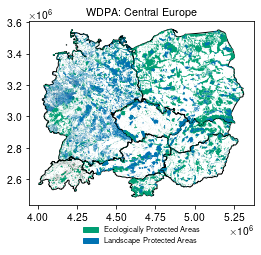

In [56]:
central_europe = ['Germany', 'Switzerland', 'Austria', 'Slovenia', 'Slovakia', 'Czech Republic', 'Hungary', 'Poland']

fig, ax = plt.subplots()

for cntry in central_europe:

    shape = gpd.read_file(ROOT + f'data/country_shapes/{cntry}.gpkg').to_crs(3035)
    pa =  gpd.read_file(ROOT + f'data/country_pa/{cntry}.gpkg')
    
    if cntry == 'Germany':
        shape.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
        pa[pa['IUCN_CAT'] != 'V'].plot(color = clrs['green'] , ax=ax)
        pa[pa['IUCN_CAT'] == 'V'].plot(color = clrs['darkblue'] , ax=ax)
    else:
        shape.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
        pa[pa['IUCN_CAT'] != 'V'].plot(color = clrs['green'], ax=ax)
        pa[pa['IUCN_CAT'] == 'V'].plot(color = clrs['darkblue'], ax=ax)

patches = [mpatches.Patch(color=c, label=l) for l,c in zip(['Ecologically Protected Areas', 'Landscape Protected Areas'],[clrs['green'],clrs['darkblue']])]   
ax.legend(handles = patches, loc = 'lower center', ncol = 1, bbox_to_anchor=(0.5, -0.25), frameon=False,  fontsize = 'x-small')

ax.set_title('WDPA: Central Europe')

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/pa.png', facecolor='w', dpi = 500)


## 3.2.3 Slopes

In [36]:
#Austria

country = gpd.read_file(ROOT + 'data/country_shapes/Austria.gpkg').to_crs(3035)

with rio.open(ROOT + 'data/input_geodata/EUD_CP_SLOP_mosaic/eudem_slop_3035_europe.tif') as src: 
    window = from_bounds(country.bounds['minx'].values, country.bounds['miny'].values, country.bounds['maxx'].values, country.bounds['maxy'].values, src.transform)
    slope = src.read(1, window=window)
    transform = rio.windows.transform(window, src.transform)
    
slope[slope == 0] = 250
 
slope = geo.dn_to_degrees(slope) 

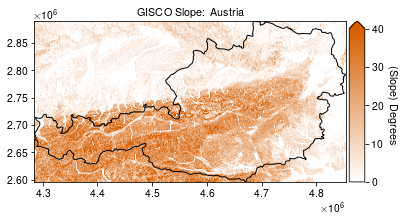

In [55]:
cmap = pltc.LinearSegmentedColormap.from_list("", ["white",lighten_color(clrs['orange'], 1)])

fig = plt.figure(figsize = figsize(1))
ax = plt.gca()

im = show(slope, transform = transform, cmap = cmap, ax=ax, vmin = 0, vmax = 40)
    
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)


ax.set_title('GISCO Slope: Austria')

plt.colorbar(im.get_images()[0], cax=cax, extend = 'max')
country.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
cax.set_ylabel('(Slope) Degrees', rotation = 270, labelpad = 15)   

fig.tight_layout(pad=0.1)
fig.savefig(ROOT + 'results/plots/slope.pdf', dpi = 500)

## 4. Results

### 4.1 Geo Potential

In [ ]:
# Forest Plots

urban_distance = 
forest_shares = [0,5,10,20]
d={}

for forest_share in forest_shares:
    with rio.open(ROOT + f'data/country_landuse_results/Germany-base-{urban_distance}-30-{forest_share}.tif') as f:
        d[int(forest_share)] = f.read(1)
        transform = f.transform

In [ ]:
germany = gpd.read_file(ROOT+'data/country_shapes/Germany.gpkg').to_crs(3035)

fig, ax = plt.subplots(1, 4, figsize = (8,6), dpi = 150) 

def area_share(mask):
    area = mask.sum().astype(float)*50**2
    share = area/germany.geometry.area.values[0]
    return int(area/1000000), round(share*100, 2)
    

show(d[0], transform=transform, cmap = 'Greens', ax=ax[0])
germany.plot(ax=ax[0], facecolor = 'none', edgecolor = 'k')
ax[0].set_title(f'area: {area_share(d[0])[0]} km**2, c. share {area_share(d[0])[1]}%', fontsize = 6, y = 1.1)

show(d[5], transform=transform, cmap = 'Greens', ax=ax[1])
germany.plot(ax=ax[1], facecolor = 'none', edgecolor = 'k')
ax[1].set_title(f'area: {area_share(d[5])[0]}  km**2, c. share {area_share(d[5])[1]}%', fontsize = 6, y = 1.1)

show(d[10], transform=transform, cmap = 'Greens', ax=ax[2])
germany.plot(ax=ax[2], facecolor = 'none', edgecolor = 'k')
ax[2].set_title(f'area: {area_share(d[10])[0]}  km**2, c. share {area_share(d[10])[1]}%', fontsize = 6, y = 1.1)

show(d[20], transform=transform, cmap = 'Greens', ax=ax[3])
germany.plot(ax=ax[3], facecolor = 'none', edgecolor = 'k')
ax[3].set_title(f'area: {area_share(d[20])[0]}  km**2, c. share {area_share(d[20])[1]}%', fontsize = 6, y = 1.1)

fig.suptitle('Germany total landuse, forest share 0%, 5%, 10% 20%. Urban distance: 1000m', y=0.75, fontsize = 10)

plt.savefig(ROOT + r'presentations\landuse_ud1000.png', bbox_inches = 'tight', dpi = 150)

### 4.2 Technical Potential

In [68]:
cntry = 'Luxembourg'
scenario = 'base'
urban_distances = ['400', '600', '800', '1000']
slopes = ['15', '30']
forest_shares = ['0', '5', '10', '20']
turbines = ['Vestas_V90_3MW', 'Vestas_V112_3MW', ('Vestas_V90_3MW', 'Vestas_V112_3MW')] 

In [69]:
store = pd.HDFStore(ROOT + f'data/country_generation_potential/{cntry}.h5')
keys = store.keys()
store.close()
keys

['/base-1000-30-5-5-Vestas_V90_3MW-Vestas_V112_3MW']

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100)

for ts in store.keys():
    ax.plot(store[ts].resample('y').sum().sum(axis=1)/1000000, label = ts)

ax.set_ylabel('TWh/year')
ax.set_title('Germany: yearly generation timeseries 96 configurations') 

#ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.4), ncol=2, frameon=False, fontsize=8)
plt.savefig(ROOT + r'presentations\results1.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

for urban_distance in urban_distances:
    for slope in slopes: 
        for turbine in turbines:
            
            ax.scatter(x = len(gpd.read_file(ROOT +f'data/country_turbine_placements/{cntry}-{scenario}-{urban_distance}-{slope}-{concat_turbine_tuple(turbine)}.gpkg')),
                       y = float(store[f'{scenario}-{urban_distance}-{slope}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                       label = f'{scenario}-{urban_distance}-{slope}-{concat_turbine_tuple(turbine)}')

ax.set_ylabel('TWh/year')
ax.set_xlabel('# of turbines')
ax.set_title('Germany: # of turbines vs. avg. yearly generation') 
ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.25), ncol=2, frameon=False, fontsize=8)
plt.savefig(r'C:\CaT\Masterthesis\repository\presentations\results2.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

for urban_distance in urban_distances:
    for slope in slopes:
        for forest_share in forest_shares:
            for turbine in turbines:
            
                ax.scatter(x = urban_distance,
                               y = float(store[f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                               label = f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}')

ax.set_ylabel('MWh/year')
ax.set_xlabel('distance to urban fabric [m]')
ax.set_title('Germany: distance to urban fabric vs. avg. yearly generation') 
#ax.legend(loc="lower center", bbox_to_anchor=(0.5, -0.45), ncol=2, frameon=False, fontsize=8)
plt.savefig(ROOT + r'presentations\results3.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=False, fontsize=8)

colors = ['#8dd3c7','#feffb3','#bfbbd9','#fa8174','#81b1d2','#fdb462','#b3de69','#bc82bd','#ccebc4','#ffed6f']
color_d = {urban_distances[i]:colors[i] for i in range(len(urban_distances))}

for urban_distance in urban_distances:
    for slope in slopes:
        for forest_share in forest_shares:
            for turbine in turbines[2]:
            
                ax.scatter(x = forest_share,
                           y = float(store[f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                           label = f'{urban_distance}m',
                           color = color_d[urban_distance]
                           )

ax.set_ylim(0)    
ax.set_ylabel('MWh/year')
ax.set_xlabel('forest_share [%]')
ax.set_title('Germany: share of forest used vs. avg. yearly generation') 

legend_without_duplicate_labels(ax)

plt.savefig(ROOT + r'presentations\results4.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=False, fontsize=8)

colors = ['#8dd3c7','#feffb3','#bfbbd9','#fa8174','#81b1d2','#fdb462','#b3de69','#bc82bd','#ccebc4','#ffed6f']
color_d = {forest_shares[i]:colors[i] for i in range(len(forest_shares))}

for urban_distance in urban_distances:
    for slope in slopes:
        for forest_share in forest_shares:
            for turbine in turbines:
            
                ax.scatter(x = urban_distance,
                           y = float(store[f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                           label = f'{forest_share}%',
                           color = color_d[forest_share]
                           )

ax.set_ylim(750)    
ax.set_ylabel('TWh/year')
ax.set_xlabel('forest_share [%]')
ax.set_title('Germany: share of forest used vs. avg. yearly generation') 

legend_without_duplicate_labels(ax)

plt.savefig(ROOT + r'presentations\results4.png', bbox_inches = 'tight', dpi = 150)

In [ ]:
fig, ax = plt.subplots(figsize = (8,5), dpi = 100) 

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=4, frameon=False, fontsize=8)

colors = ['#8dd3c7','#feffb3','#bfbbd9','#fa8174','#81b1d2','#fdb462','#b3de69','#bc82bd','#ccebc4','#ffed6f']
color_d = {turbines[i]:colors[i] for i in range(len(turbines))}

for urban_distance in urban_distances:
    for slope in slopes:
        for forest_share in forest_shares:
            for turbine in turbines:
            
                ax.scatter(x = forest_share,
                           y = float(store[f'{scenario}-{urban_distance}-{slope}-{forest_share}-{concat_turbine_tuple(turbine)}'].resample('y').sum().sum(axis=1).mean()/1000000),
                           label = f'{concat_turbine_tuple(turbine)}',
                           color = color_d[turbine]
                           )

ax.set_ylim(0)    
ax.set_ylabel('MWh/year')
ax.set_xlabel('forest_share [%]')
ax.set_title('Germany: share of forest used vs. avg. yearly generation') 

legend_without_duplicate_labels(ax)

plt.savefig(ROOT + r'presentations\results4.png', bbox_inches = 'tight', dpi = 150)

## 5. Conclusion